In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os, time, multiprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import offsetbox
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from scipy.linalg import eigh

In [3]:
raw_data = pd.read_csv('/content/gdrive/MyDrive/digit-recognizer/train.csv')
print(raw_data.info())
print(raw_data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0    

Since the initial data has been labeled, the team dicided to remove the label comlumn for the project

In [4]:
labels = raw_data['label']
new_data = raw_data.drop(columns=['label'], axis = 1)
print(new_data.head(5))

   pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0   

**The total number of numbers in the project**

<ipython-input-5-faaf7936b485>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  counts = sns.countplot(x="label", data=raw_data, palette="Set1")


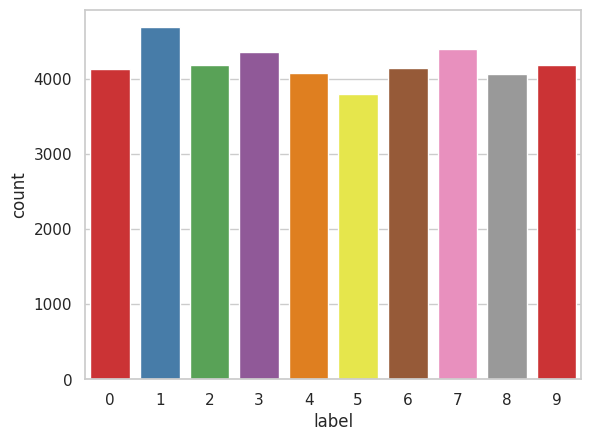

In [5]:
sns.set(style="whitegrid")
counts = sns.countplot(x="label", data=raw_data, palette="Set1")

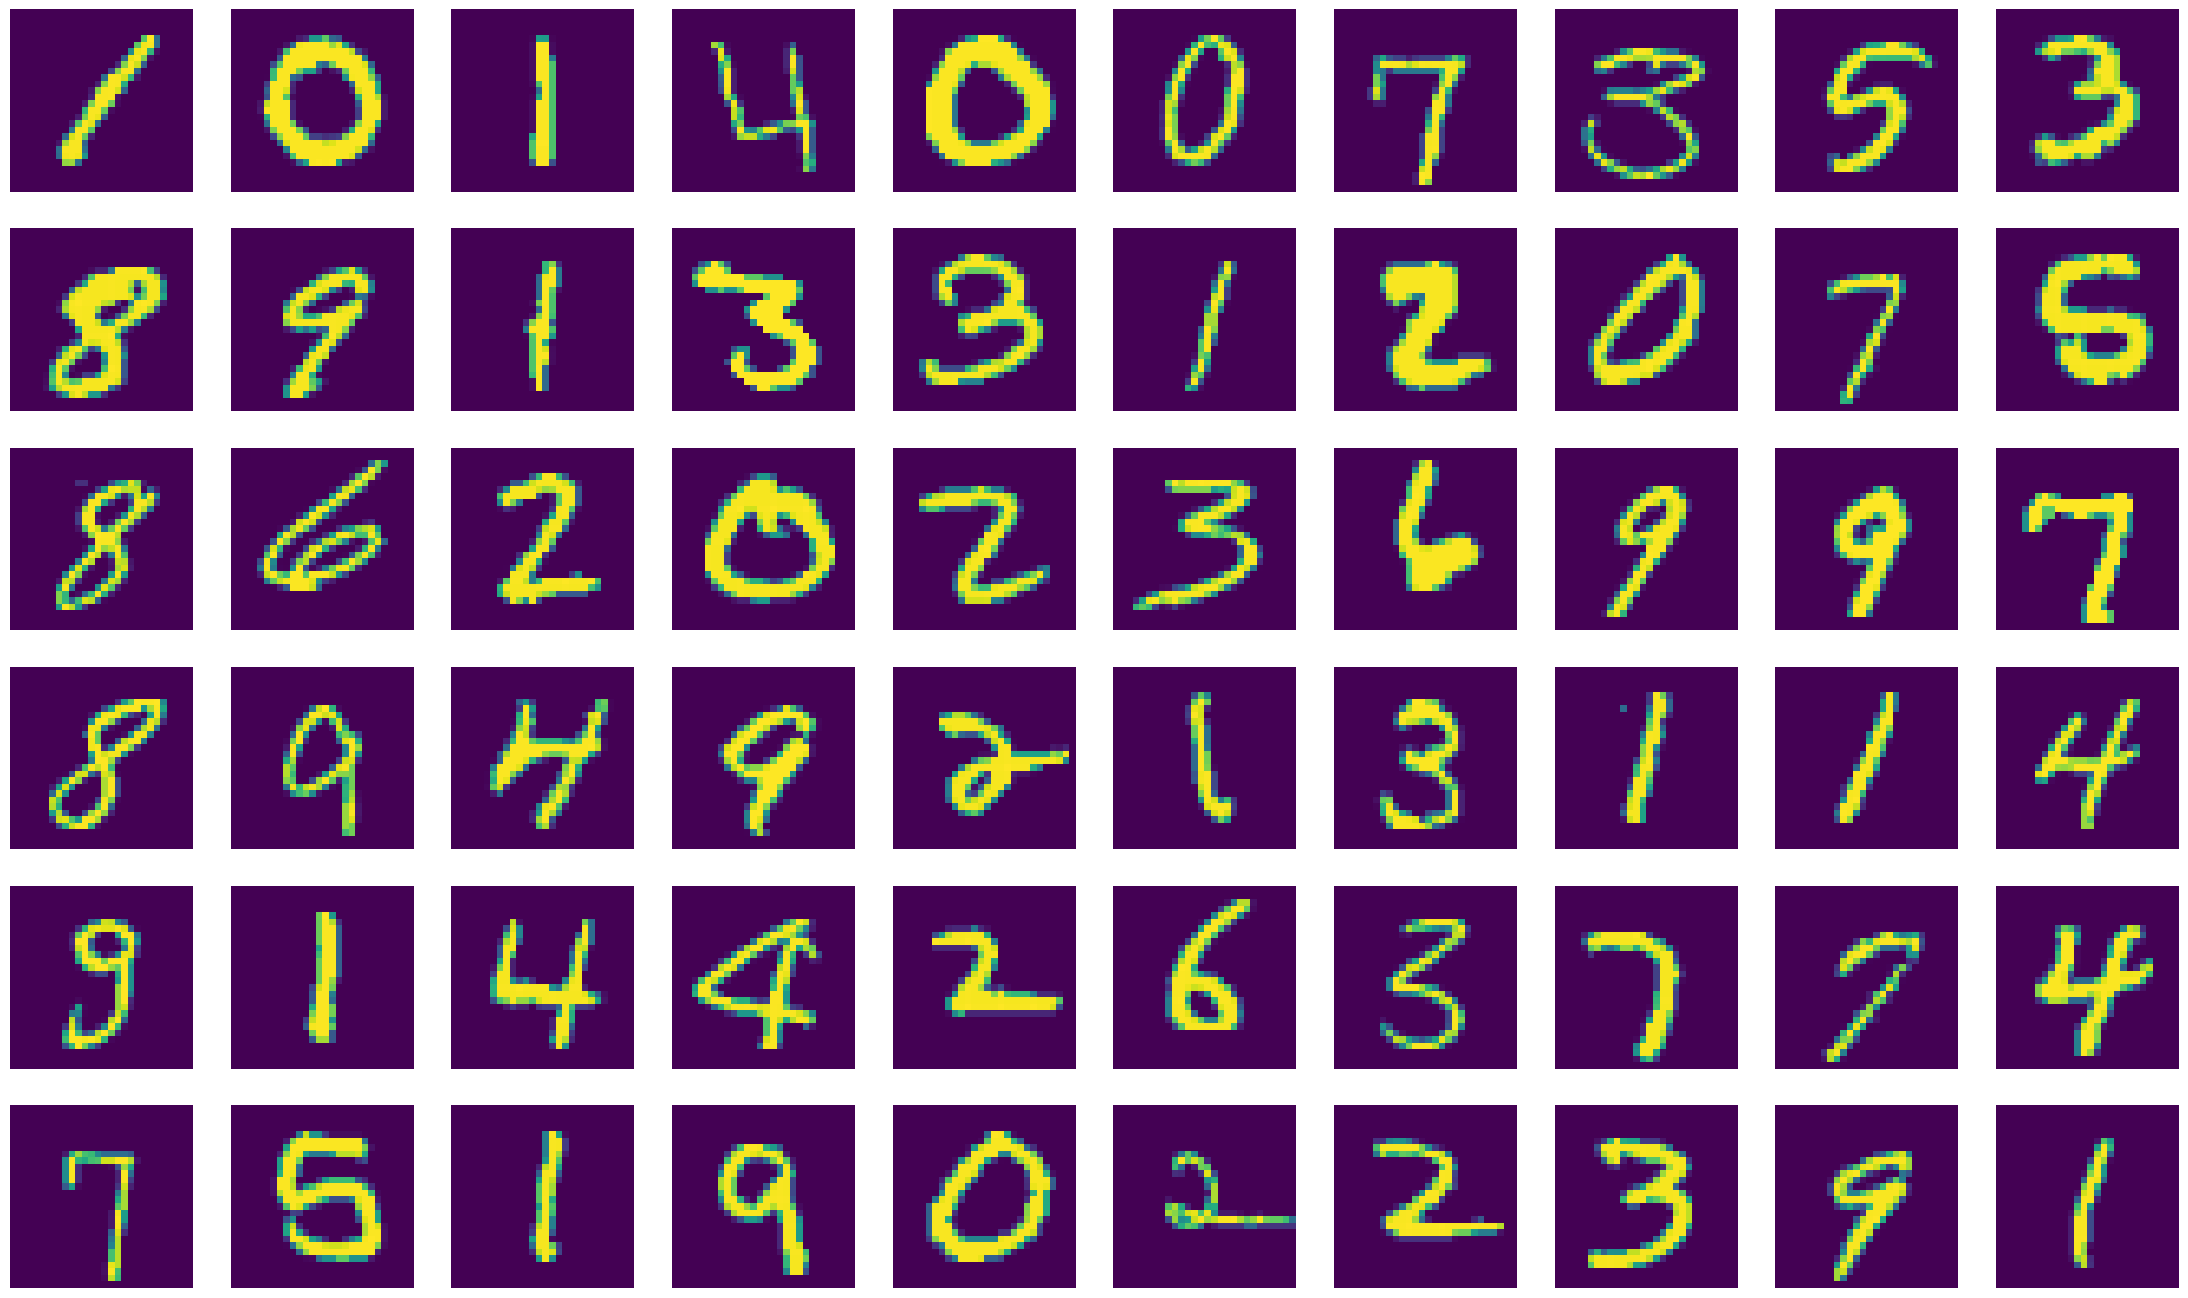

In [6]:
plt.figure(figsize=(28,28))
for digit_num in range(60):
  plt.subplot(10,10,digit_num+1)
  grid_data = new_data.iloc[digit_num].values.reshape(28,28)
  plt.imshow(grid_data,interpolation = 'none', cmap='viridis')
  plt.axis('off')

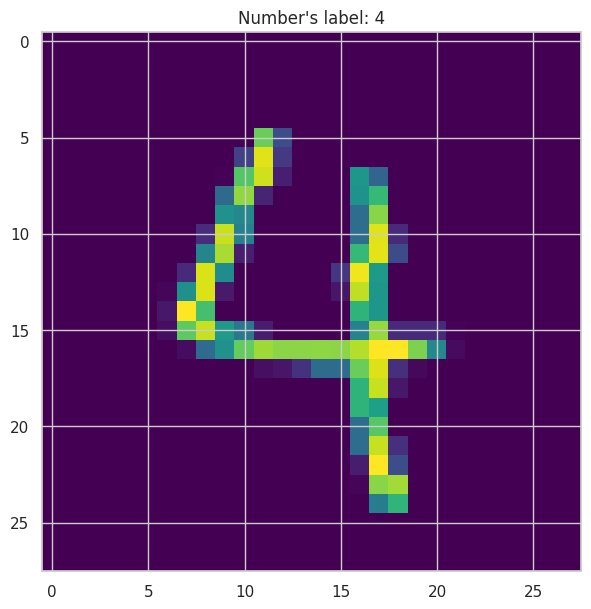

In [7]:
plt.figure(figsize=(7,7))
index = 999
grid_number = new_data.iloc[index].values.reshape(28,28)
plt.imshow(grid_number,interpolation='none', cmap='viridis')
plt.title(f"Number\'s label: {labels[index]}")
plt.show()



**Due to the large amount of data, the team decided to only half of it to facilitate visualization**

In [8]:
label = labels.head(20000)
data = new_data.head(20000)
print("New sample data:", data.shape)

New sample data: (20000, 784)


**Standards values**

In [9]:
from sklearn.preprocessing import StandardScaler
standard_data = StandardScaler().fit_transform(data)
print(standard_data.shape)

(20000, 784)


In [10]:
#find co-variance matrix
sample_data = standard_data
cov_matrix = np.matmul(sample_data.T, sample_data)
print(cov_matrix.shape)

(784, 784)


In [11]:
from scipy.linalg import eigh
import numpy as np

def pca_function(n_feature, sample_data, labels):
    # Trim labels if the numbers does not match
    if sample_data.shape[0] != labels.shape[0]:
        print(f"Warning: sample_data has {sample_data.shape[0]} samples but labels has {labels.shape[0]} → trimming labels.")
        labels = labels[:sample_data.shape[0]]

    # Calculate the covariance matrix
    cov_matrix = np.cov(sample_data.T)
    dim = cov_matrix.shape[0]
    print("Covariance matrix shape:", cov_matrix.shape)

    # Extract eigenvalues & eigenvectors
    values, vectors = eigh(cov_matrix, subset_by_index=(dim - n_feature, dim - 1))
    print("Shape of eigen vectors:", vectors.shape)

    # Transpose eigenvectors so that each vector is a row
    vectors = vectors.T
    print("Updated shape of eigen vectors:", vectors.shape)

    # Transform data into the new space
    new_data = np.matmul(vectors, sample_data.T)
    print("New data shape", vectors.shape, "X", sample_data.T.shape, "=", new_data.shape)

    # Attach labels to the new data
    labels_array = labels.to_numpy().reshape(1, -1) if hasattr(labels, "to_numpy") else labels.reshape(1, -1)
    new_data = np.vstack((new_data, labels_array)).T
    print("Final transformed data shape (with labels):", new_data.shape)

    return values, vectors, new_data


In [12]:
a, b, transformed_data = pca_function(2, sample_data, labels)


Covariance matrix shape: (784, 784)
Shape of eigen vectors: (784, 2)
Updated shape of eigen vectors: (2, 784)
New data shape (2, 784) X (784, 20000) = (2, 20000)
Final transformed data shape (with labels): (20000, 3)


In [13]:
transformed_data.shape

(20000, 3)

<ipython-input-14-9b0f62dc36a3>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('Spectral', 10),


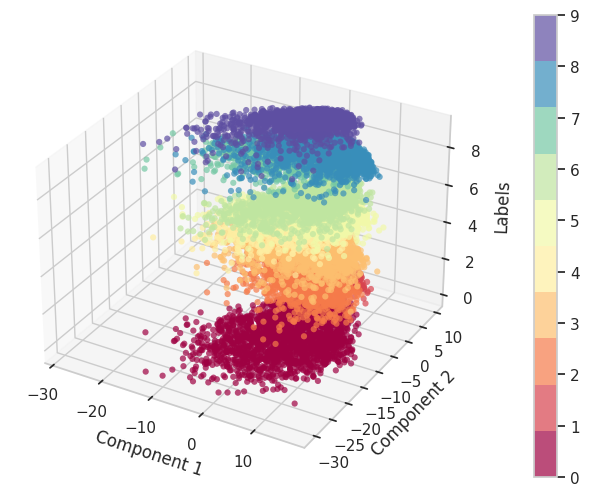

In [14]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(transformed_data[:, 0],
                transformed_data[:, 1],
                transformed_data[:, 2],
                c=transformed_data[:, 2],
                cmap=plt.cm.get_cmap('Spectral', 10),
                alpha=0.7,
                edgecolor='none')

# Label axes
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Labels')

# Add color bar
fig.colorbar(sc, ax=ax, pad=0.1)
plt.show()


In [15]:
fig, plot = plt.subplots()
fig.set_size_inches(28,28)
plot.scatter(transformed_data[:,0], transformed_data[:,1], c=transformed_data[:,2])
plot.set_xticks(())
plot.set_yticks(())
plt.tight_layout()
plt.show()
# fig = plt.figure(figsize=(28,28))
# ax = fig.add_subplot(111,projection='3d')

# sc = ax.scatter(
#     transformed_data[:, 0],
#     transformed_data[:, 1],
#     transformed_data[:, 2],
#     c=transformed_data[:, 2],
#     cmap='tab10'
# )
# # ax.set_xticks([])
# # ax.set_yticks([])
# # ax.set_zticks([])

# plt.tight_layout()
# plt.show()

Output hidden; open in https://colab.research.google.com to view.

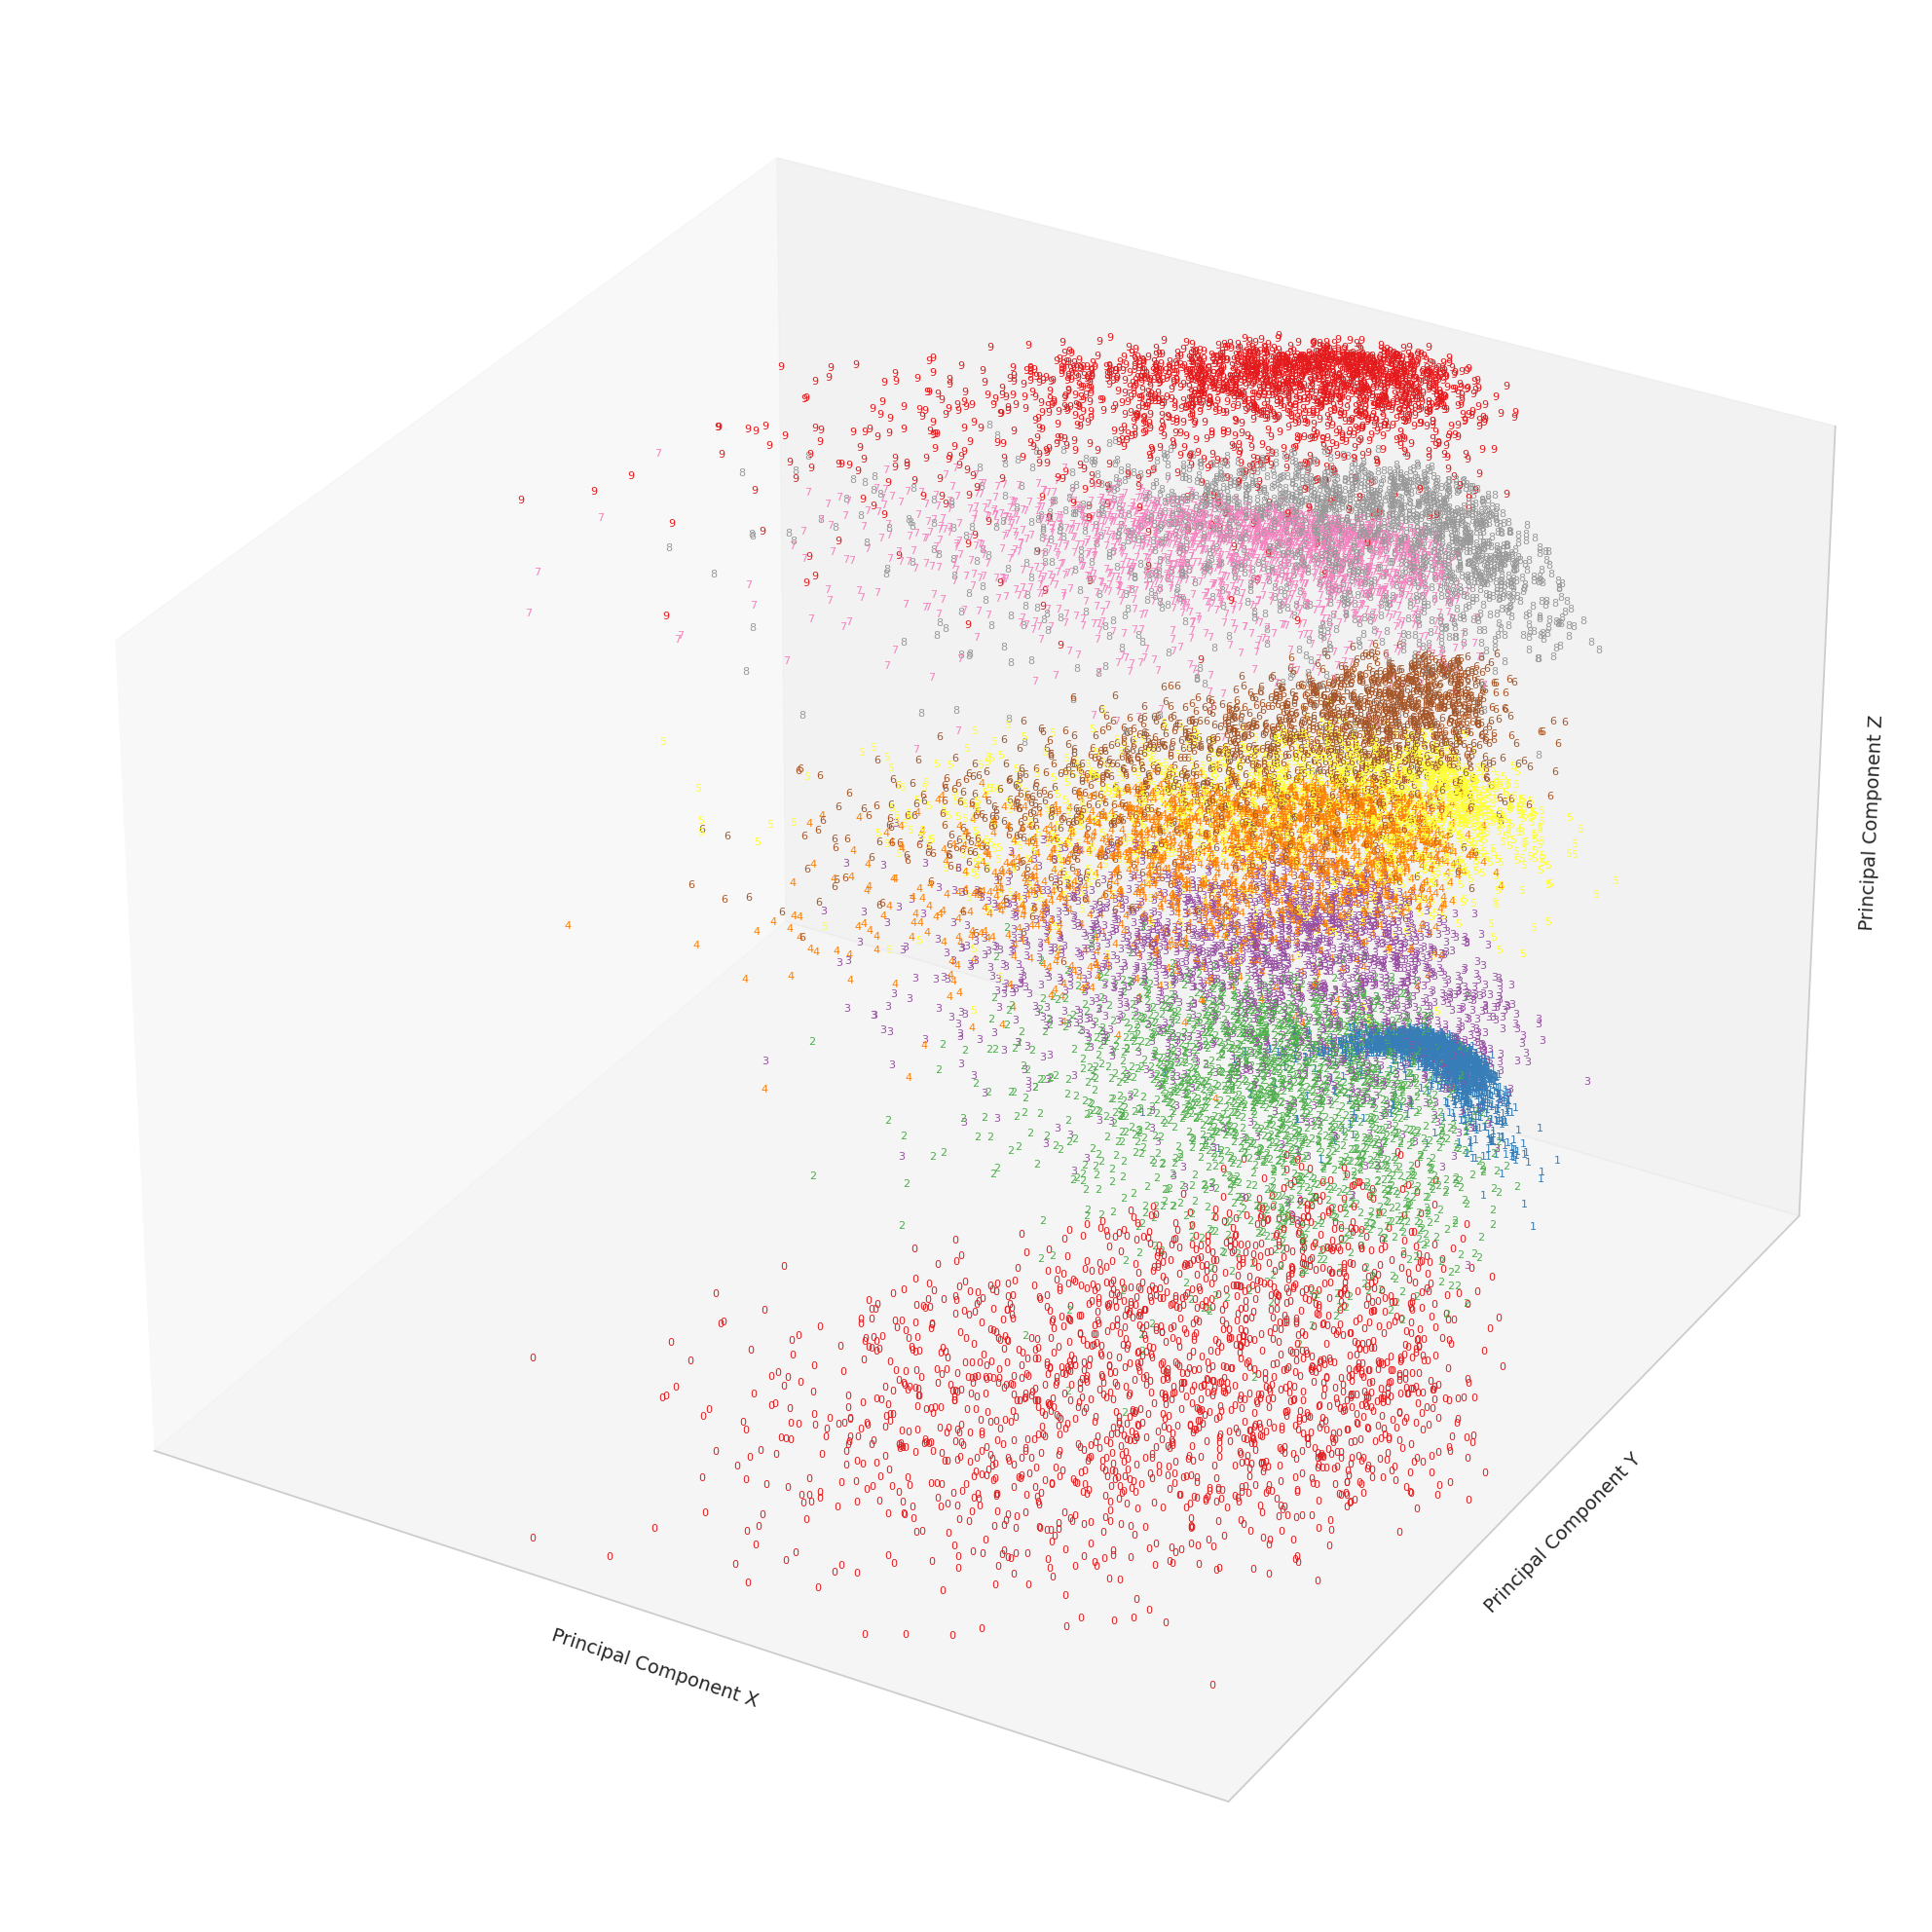

In [16]:

def emPlot_3D(X, labels, title=None):
    if X.shape[1] < 3:
        raise ValueError("Input X must have at least 3 dimensions for 3D plot.")

    x_min, x_max = np.min(X, axis=0), np.max(X, axis=0)
    X = (X - x_min) / (x_max - x_min)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(len(X)):
        ax.text(X[i, 0], X[i, 1], X[i, 2], str(labels[i]),
                color=plt.cm.Set1(labels[i] % 9),
                fontsize=8)

    ax.set_xlabel('Principal Component X', fontsize=14)
    ax.set_ylabel('Principal Component Y', fontsize=14)
    ax.set_zlabel('Principal Component Z', fontsize=14)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    if title:
        ax.set_title(title, fontsize=16)

    plt.tight_layout()
    plt.show()
emPlot_3D(transformed_data[:, 0:3], labels)

In [17]:
pca_values, pca_vectors, new_datachoosen =  pca_function(20, sample_data, labels)

Covariance matrix shape: (784, 784)
Shape of eigen vectors: (784, 20)
Updated shape of eigen vectors: (20, 784)
New data shape (20, 784) X (784, 20000) = (20, 20000)
Final transformed data shape (with labels): (20000, 21)


In [18]:
from sklearn import svm,metrics
from sklearn.model_selection import train_test_split
n=20
X_train,X_test,y_train,y_test = train_test_split(new_datachoosen[:,:n],new_datachoosen[:,n],test_size=0.3,shuffle=False)

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm, metrics
import time

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.0001],
    'kernel': ['rbf']
}

grid = GridSearchCV(svm.SVC(), param_grid, verbose=2, n_jobs=-1, cv=3)

# Đo thời gian
time_start = time.time()

# Train
grid.fit(X_train, y_train)

# Predict
predicted = grid.predict(X_test)

# Print the result
print("Best parameters found: ", grid.best_params_)
print("\nClassification report:\n", metrics.classification_report(y_test, predicted))
print("\nAccuracy = {:.4f}".format(metrics.accuracy_score(y_test, predicted)))

# Running time
time_end = time.time()
print('Time to classify: %.2f minutes.' % ((time_end - time_start) / 60))


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters found:  {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Classification report:
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       561
         1.0       0.98      0.99      0.98       691
         2.0       0.93      0.97      0.95       583
         3.0       0.93      0.92      0.93       670
         4.0       0.94      0.94      0.94       603
         5.0       0.95      0.93      0.94       518
         6.0       0.97      0.97      0.97       583
         7.0       0.96      0.95      0.95       606
         8.0       0.92      0.92      0.92       572
         9.0       0.92      0.92      0.92       613

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000


Accuracy = 0.9490
Time to classify: 1.63 minutes.


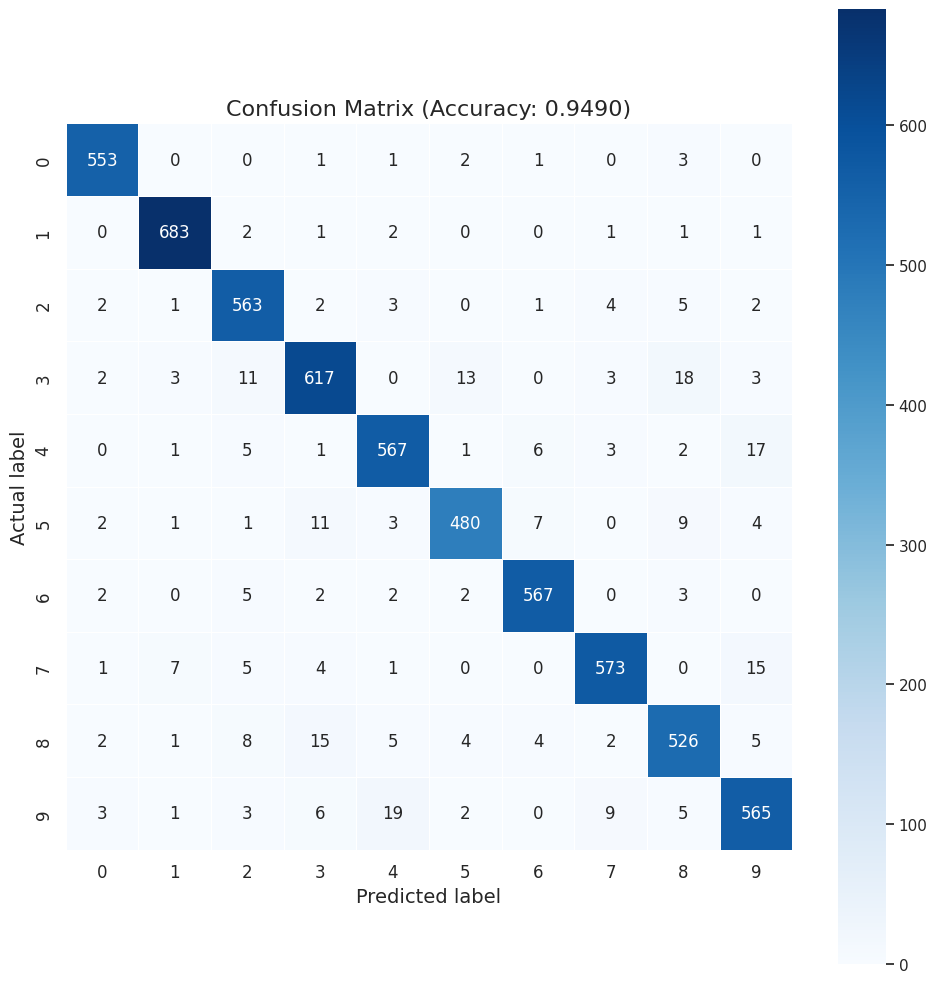

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Calculate confusion matrix
cmp = confusion_matrix(y_test, predicted)
acc = accuracy_score(y_test, predicted)

# Draw heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cmp, annot=True, fmt='d', cmap='Blues', linewidths=.5, square=True)

plt.title(f'Confusion Matrix (Accuracy: {acc:.4f})', fontsize=16)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('Actual label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
